In [13]:
import tensorflow as tf
import copy
import os

from tensorflow.contrib import rnn
from tensorflow.python.ops import variable_scope
from tensorflow.python.framework import dtypes

import matplotlib.pyplot as plt
import seaborn as sns

# 图形出现在Notebook里而不是新窗口
%matplotlib inline

class Seq2SeqTraining():
    def __init__(self):
        ## Parameters
        self.learning_rate = 0.001
        self.lambda_l2_reg = 0.004 
        
        self.total_iteractions = 500
        self.batch_size = 20
        self.KEEP_RATE = 0.5

        ## Network Parameters
        # length of input signals
        self.input_seq_len = 24
        # length of output signals
        self.output_seq_len = 24

        # size of LSTM Cell
        self.hidden_dim = 64
        # num of input signals
        self.input_dim = 1
        # num of output signals
        self.output_dim = 1
        # num of stacked lstm layers
        self.num_stacked_layers = 2
        # gradient clipping - to avoid gradient exploding
        self.GRADIENT_CLIPPING = 2.5
        
        #model saving
        self.modelSavePath = "./seq2seqTimeSeries"
        self.modelSaveName = "univariate_ts_model0"
        
    def build_graph(self, feed_previous = False):
 
        tf.reset_default_graph()

        global_step = tf.Variable(
                      initial_value=0,
                      name="global_step",
                      trainable=False,
                      collections=[tf.GraphKeys.GLOBAL_STEP, tf.GraphKeys.GLOBAL_VARIABLES])

        weights = {
            'out': tf.get_variable('Weights_out', \
                                   shape = [self.hidden_dim, self.output_dim], \
                                   dtype = tf.float32, \
                                   initializer = tf.truncated_normal_initializer()),
        }
        biases = {
            'out': tf.get_variable('Biases_out', \
                                   shape = [self.output_dim], \
                                   dtype = tf.float32, \
                                   initializer = tf.constant_initializer(0.)),
        }

        with tf.variable_scope('Seq2seq'):
            # Encoder: inputs
            enc_inp = [
                tf.placeholder(tf.float32, shape=(None, self.input_dim), name="inp_{}".format(t))
                   for t in range(self.input_seq_len)
            ]

            # Decoder: target outputs
            target_seq = [
                tf.placeholder(tf.float32, shape=(None, self.output_dim), name="y".format(t))
                  for t in range(self.output_seq_len)
            ]

            # Give a "GO" token to the decoder.
            # If dec_inp are fed into decoder as inputs, this is 'guided' training; otherwise only the
            # first element will be fed as decoder input which is then 'un-guided'
            dec_inp = [ tf.zeros_like(target_seq[0], dtype=tf.float32, name="GO") ] + target_seq[:-1]

            with tf.variable_scope('LSTMCell'):
                cells = []
                for i in range(self.num_stacked_layers):
                    with tf.variable_scope('RNN_{}'.format(i)):
                        cells.append(tf.contrib.rnn.LSTMCell(self.hidden_dim))
                cell = tf.contrib.rnn.MultiRNNCell(cells)

            def _rnn_decoder(decoder_inputs,
                            initial_state,
                            cell,
                            loop_function=None,
                            scope=None):
              """RNN decoder for the sequence-to-sequence model.
              Args:
                decoder_inputs: A list of 2D Tensors [batch_size x input_size].
                initial_state: 2D Tensor with shape [batch_size x cell.state_size].
                cell: rnn_cell.RNNCell defining the cell function and size.
                loop_function: If not None, this function will be applied to the i-th output
                  in order to generate the i+1-st input, and decoder_inputs will be ignored,
                  except for the first element ("GO" symbol). This can be used for decoding,
                  but also for training to emulate http://arxiv.org/abs/1506.03099.
                  Signature -- loop_function(prev, i) = next
                    * prev is a 2D Tensor of shape [batch_size x output_size],
                    * i is an integer, the step number (when advanced control is needed),
                    * next is a 2D Tensor of shape [batch_size x input_size].
                scope: VariableScope for the created subgraph; defaults to "rnn_decoder".
              Returns:
                A tuple of the form (outputs, state), where:
                  outputs: A list of the same length as decoder_inputs of 2D Tensors with
                    shape [batch_size x output_size] containing generated outputs.
                  state: The state of each cell at the final time-step.
                    It is a 2D Tensor of shape [batch_size x cell.state_size].
                    (Note that in some cases, like basic RNN cell or GRU cell, outputs and
                     states can be the same. They are different for LSTM cells though.)
              """
              with variable_scope.variable_scope(scope or "rnn_decoder"):
                state = initial_state
                outputs = []
                prev = None
                for i, inp in enumerate(decoder_inputs):
                  if loop_function is not None and prev is not None:
                    with variable_scope.variable_scope("loop_function", reuse=True):
                      inp = loop_function(prev, i)
                  if i > 0:
                    variable_scope.get_variable_scope().reuse_variables()
                  output, state = cell(inp, state)
                  outputs.append(output)
                  if loop_function is not None:
                    prev = output
              return outputs, state

            def _basic_rnn_seq2seq(encoder_inputs,
                                  decoder_inputs,
                                  cell,
                                  feed_previous,
                                  dtype=dtypes.float32,
                                  scope=None):
              """Basic RNN sequence-to-sequence model.
              This model first runs an RNN to encode encoder_inputs into a state vector,
              then runs decoder, initialized with the last encoder state, on decoder_inputs.
              Encoder and decoder use the same RNN cell type, but don't share parameters.
              Args:
                encoder_inputs: A list of 2D Tensors [batch_size x input_size].
                decoder_inputs: A list of 2D Tensors [batch_size x input_size].
                feed_previous: Boolean; if True, only the first of decoder_inputs will be
                  used (the "GO" symbol), all other inputs will be generated by the previous
                  decoder output using _loop_function below. If False, decoder_inputs are used
                  as given (the standard decoder case).
                dtype: The dtype of the initial state of the RNN cell (default: tf.float32).
                scope: VariableScope for the created subgraph; default: "basic_rnn_seq2seq".
              Returns:
                A tuple of the form (outputs, state), where:
                  outputs: A list of the same length as decoder_inputs of 2D Tensors with
                    shape [batch_size x output_size] containing the generated outputs.
                  state: The state of each decoder cell in the final time-step.
                    It is a 2D Tensor of shape [batch_size x cell.state_size].
              """
              with variable_scope.variable_scope(scope or "basic_rnn_seq2seq"):
                enc_cell = copy.deepcopy(cell)
                _, enc_state = rnn.static_rnn(enc_cell, encoder_inputs, dtype=dtype)
                if feed_previous:
                    return _rnn_decoder(decoder_inputs, enc_state, cell, _loop_function)
                else:
                    return _rnn_decoder(decoder_inputs, enc_state, cell)

            def _loop_function(prev, _):
              '''Naive implementation of loop function for _rnn_decoder. Transform prev from
              dimension [batch_size x hidden_dim] to [batch_size x output_dim], which will be
              used as decoder input of next time step '''
              return tf.matmul(prev, weights['out']) + biases['out']

            dec_outputs, dec_memory = _basic_rnn_seq2seq(
                enc_inp,
                dec_inp,
                cell,
                feed_previous = feed_previous
            )

            reshaped_outputs = [tf.matmul(i, weights['out']) + biases['out'] for i in dec_outputs]

        # Training loss and optimizer
        with tf.variable_scope('Loss'):
            # L2 loss
            output_loss = 0
            for _y, _Y in zip(reshaped_outputs, target_seq):
                output_loss += tf.reduce_mean(tf.pow(_y - _Y, 2))

            # L2 regularization for weights and biases
            reg_loss = 0
            for tf_var in tf.trainable_variables():
                if 'Biases_' in tf_var.name or 'Weights_' in tf_var.name:
                    reg_loss += tf.reduce_mean(tf.nn.l2_loss(tf_var))

            loss = output_loss + self.lambda_l2_reg * reg_loss

        with tf.variable_scope('Optimizer'):
            optimizer = tf.contrib.layers.optimize_loss(
                    loss=loss,
                    learning_rate=self.learning_rate,
                    global_step=global_step,
                    optimizer='Adam',
                    clip_gradients=self.GRADIENT_CLIPPING)

        saver = tf.train.Saver

        return dict(
            enc_inp = enc_inp,
            target_seq = target_seq,
            train_op = optimizer,
            loss=loss,
            saver = saver,
            reshaped_outputs = reshaped_outputs,
            )

    def train(self, batchGenerator):
        rnn_model = self.build_graph(feed_previous=False)
 
        saver = tf.train.Saver()

        init = tf.global_variables_initializer()
        with tf.Session() as sess:

            sess.run(init)

            i = 0 
            for i in range(self.total_iteractions):
                batch_input, batch_output = batchGenerator #generate_train_samples(batch_size=batch_size)

                feed_dict = {rnn_model['enc_inp'][t]: batch_input[:,t].reshape(-1,self.input_dim) for t in range(self.input_seq_len)}
                feed_dict.update({rnn_model['target_seq'][t]: batch_output[:,t].reshape(-1,self.output_dim) for t in range(self.output_seq_len)})
                _, loss_t = sess.run([rnn_model['train_op'], rnn_model['loss']], feed_dict)
                i = i + 1
                if (i%50 ==0):
                    print(loss_t)

            temp_saver = rnn_model['saver']()
            save_path = temp_saver.save(sess, os.path.join(self.modelSavePath, self.modelSaveName))
        
    def predict(self,test_seq_input):
        rnn_model = self.build_graph(feed_previous=True)
 
        init = tf.global_variables_initializer()
        with tf.Session() as sess:

            sess.run(init)
            saver = rnn_model['saver']().restore(sess, os.path.join(self.modelSavePath, self.modelSaveName))

            feed_dict = {rnn_model['enc_inp'][t]: test_seq_input[t].reshape(1,1) for t in range(self.input_seq_len)}
            feed_dict.update({rnn_model['target_seq'][t]: np.zeros([1, self.output_dim]) for t in range(self.output_seq_len)})
            final_preds = sess.run(rnn_model['reshaped_outputs'], feed_dict)

            final_preds = np.concatenate(final_preds, axis = 1)
            
        return final_preds
    

In [14]:
from datetime import date, timedelta
import pandas as pd
import numpy as np
from pandas import Series, DataFrame

class DataLoader():
    def __init__(self, csvPath):
        self.csvPath = csvPath
        self.loadData()
        
    def loadData(self):
        self.df_train = pd.read_csv(self.csvPath)
        self.df_train["everyDayHour"] =  self.df_train['everyDayHour'].map(lambda strDateHour: "20"+strDateHour[6:8] 
                                                         + "/" + strDateHour[0:5] + " "
                                                         + strDateHour[9:11] + ":00:00")
        self.df_train["metric"] = "cpu"
        self.df_train["everyDayHour"] = pd.to_datetime(self.df_train["everyDayHour"], format='%Y%m%d %H:%M:%S')
        self.df_train = self.df_train.astype({"avg(cpu)":'float'})
        
        self.df_train = self.df_train.pivot(index="metric",columns="everyDayHour",values="avg(cpu)")
        
    def get_timespan(self, df, datetimeStart, minus, periods, freq='H'):
        return df[pd.date_range(datetimeStart - timedelta(hours=minus), periods=periods, freq=freq)]
    
    def prepare_dataset(self, df, datetimeStart, is_train=True, name_prefix=None):
        X = {}
        #for i in [2, 7, 14, 28]:
        for i in [2]:
            tmp = self.get_timespan(df, datetimeStart, i, i)
            #X['diff_%s_mean' % i] = tmp.diff(axis=1).mean(axis=1).values
            #X['mean_%s_decay' % i] = (tmp * np.power(0.9, np.arange(i)[::-1])).sum(axis=1).values
            #X['mean_%s' % i] = tmp.mean(axis=1).values
            X['median_%s' % i] = tmp.median(axis=1).values
            #X['min_%s' % i] = tmp.min(axis=1).values
            #X['max_%s' % i] = tmp.max(axis=1).values
            #X['std_%s' % i] = tmp.std(axis=1).values

        for i in range(1, 24):
            X['hour_%s_2019' % i] = self.get_timespan(df, datetimeStart, i, 1).values.ravel()


        X = pd.DataFrame(X)

        # start date and periods is 24 hours
        if is_train:
            yInput = df[pd.date_range(datetimeStart, periods=24, freq='H')].values
            yTarget = df[pd.date_range(datetimeStart + timedelta(hours=1), periods=24, freq='H')].values
            return X, yInput, yTarget

        return X
    
    #startDateTime = "2019-05-21 02:00:00"
    # numHours = 3800
    def prepareTrainingData(self,startDateTime, numHours):
        X_l, y_lIn, y_lTg = [], [], []

        t2019Jul19 = pd.to_datetime(startDateTime, format='%Y%m%d %H:%M:%S')
        num_hours = numHours
        for i in range(num_hours):
            delta = timedelta(hours = i)
            X_tmp, y_tmp1, y_tmp2 = self.prepare_dataset(self.df_train, t2019Jul19 + delta)

            X_l.append(X_tmp)
            y_lIn.append(y_tmp1)
            y_lTg.append(y_tmp2)

        X_train = pd.concat(X_l, axis=0)
        print(X_train.shape)
        #DataFrame(X_train).to_csv("x_train_sfdc.csv")

        y_trainIn = np.concatenate(y_lIn, axis=0)
        y_trainTarget = np.concatenate(y_lTg, axis=0)
        #DataFrame(y_trainIn).to_csv("y_trainIn_sfdc.csv")
        #DataFrame(y_trainTarget).to_csv("y_trainTarget_sfdc.csv")
        X_train = X_train.as_matrix()

        #reshape to 3D shape for X
        X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))

        print(X_train.shape)

        y_trainIn = DataFrame(y_trainIn).as_matrix()
        y_trainIn = y_trainIn.reshape((y_trainIn.shape[0], y_trainIn.shape[1], 1))
        print(y_trainIn.shape)

        y_trainTarget = DataFrame(y_trainTarget).as_matrix()
        y_trainTarget = y_trainTarget.reshape((y_trainTarget.shape[0], y_trainTarget.shape[1], 1))
        
        return X_train, y_trainTarget
    
    def generate_x_y_data(self, X_train, y_trainTarget, isTrain=True, batch_size=10):
        # shape: (batch_size, seq_length, output_dim)
        idx = 0
        while True:
            if idx + batch_size > X_train.shape[0]:
                idx = 0
            start = idx
            idx += batch_size
            yield X_train[start:start+batch_size,:,:], y_trainTarget[start:start+batch_size,:,:]

        # shape: (seq_length, batch_size, output_dim)
        return None
        

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# 图形出现在Notebook里而不是新窗口
%matplotlib inline


def plotPoints(dataPoints, label):
    plt.figure(figsize=(12, 6))
    plt.plot(dataPoints, label="Original Data")
    

In [16]:
dataLoader = DataLoader("../../../data/sflogs/loadCPU04t.csv")
X_train, y_trainTarget = dataLoader.prepareTrainingData("2019-05-21 02:00:00", 3800)

#plotPoints(X_train[1], "Data Points")

(3800, 24)
(3800, 24, 1)
(3800, 24, 1)


In [17]:
#plotPoints(y_trainTarget[1], "Data Points Y")

(15, 24, 1)
(15, 24, 1)


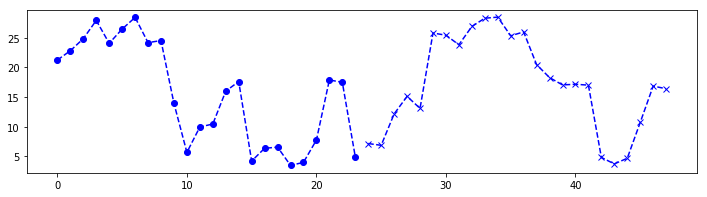

In [18]:
def generate_x_y_data(X_train, y_trainTarget, isTrain=True, batch_size=10):
    # shape: (batch_size, seq_length, output_dim)
    idx = 0
    while True:
        if idx + batch_size > X_train.shape[0]:
            idx = 0
        start = idx
        idx += batch_size
        yield X_train[start:start+batch_size,:,:], y_trainTarget[start:start+batch_size,:,:]
    return None
#batch size, sequence length, dimension
generateBatch = generate_x_y_data(X_train, y_trainTarget, isTrain=True, batch_size=15)

xN, yN = next(generateBatch)
print(xN.shape)
print(yN.shape)

past = xN[1,:,:]
expected = yN[1,:,:] 
        
plt.figure(figsize=(12, 3))

plt.plot(range(len(past)), past, "o--b", label="Seen (past) values")
plt.plot(range(len(past), len(expected)+len(past)), expected, "x--b", label="True future values")

In [19]:
seq2Seq = Seq2SeqTraining()
print(seq2Seq)
seq2Seq.build_graph()
seq2Seq.train(next(generateBatch))

243.1578
98.77211
59.17106
43.815125
38.737694
27.564953
16.944223
22.91577
16.013475
11.215704


(15, 24, 1)
(1, 24)


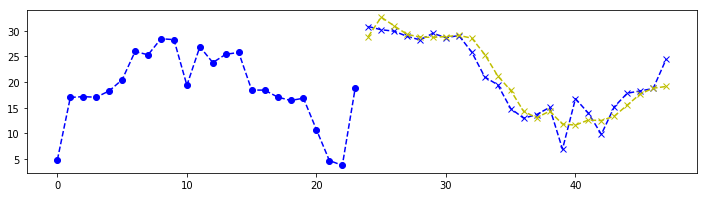

In [20]:
xTest, yTest = next(generateBatch)
print(xTest.shape)

testIndex = 0
yPredict = seq2Seq.predict(xTest[testIndex])
print(yPredict.shape)

past = xTest[testIndex,:,:]
expected = yTest[testIndex,:,:] 

future =  yPredict[0,:]
        
plt.figure(figsize=(12, 3))

plt.plot(range(len(past)), past, "o--b", label="Seen (past) values")
plt.plot(range(len(past), len(expected)+len(past)), expected, "x--b", label="True future values")
plt.plot(range(len(past), len(future)+len(past)), future, "x--y", label="Predicted future values")

np.savetxt('./realvalues.csv',np.concatenate((past, expected), axis=0),delimiter=',')
np.savetxt('./predictedvalues.csv',future,delimiter=',')